In [1]:
import matplotlib.pyplot as plt
import scipy.integrate
import torch
import sys  
sys.path.insert(0, '../../..')

from hnn.simulation.mve_ensemble import MveEnsembleHamiltonianDynamics
from hnn.utils import integrate_model
from hnn.train import train
from hnn.types import TrajectoryArgs

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=300, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-4, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=5000, type=int, help='number of gradient steps')
    parser.add_argument('--field_type', default='conservative', type=str, help='type of vector field to learn') # solenoidal, conservative
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

In [3]:
# Test the MVE ensemble Hamiltonian function

from hnn.simulation.mve_ensemble.mve_ensemble import mve_ensemble_fn, get_initial_conditions

coords, masses = get_initial_conditions(4)

# Hamiltonian for the ensemble
H = mve_ensemble_fn(coords, masses)
print("Hamiltonian (Total Energy):", H.item())

Hamiltonian (Total Energy): 94.4486083984375


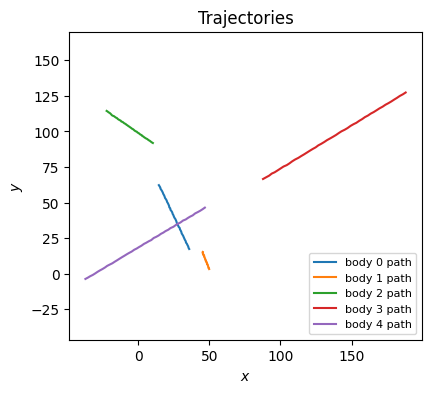

In [4]:
hamiltonian = MveEnsembleHamiltonianDynamics()
q, p, dq, dp, t = hamiltonian.get_trajectory({})
positions = q.transpose(0, 1)
time = t

fig = plt.figure(figsize=[10,4], dpi=100)
p1 = plt.subplot(1,2,1)
plt.title('Trajectories')
for i, pos in enumerate(positions):
    x, y = pos[:, 0], pos[:, 1]
    plt.plot(x, y, label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$x$') ; plt.ylabel('$y$')
plt.legend(fontsize=8)


LJP torch.Size([50])
KE torch.Size([50]) torch.Size([5, 50, 2])


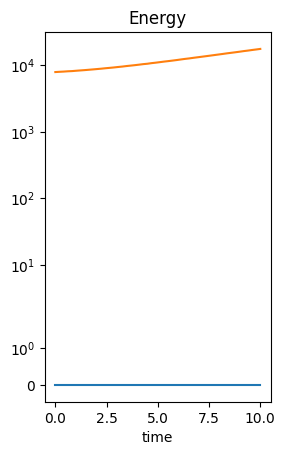

In [6]:
from hnn.simulation.mve_ensemble.mve_ensemble import calc_lennard_jones_potential, calc_kinetic_energy
ljp = calc_lennard_jones_potential(positions)
masses = torch.ones(5)
ke = calc_kinetic_energy(positions, masses)
print("LJP", ljp.shape)
print("KE", ke.shape)

p2 = plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
p2.set_yscale('symlog')
plt.plot(time, ljp, label='potential')
plt.plot(time, ke, label='kinetic')

In [ ]:
args = get_args()

data = hamiltonian.get_dataset({}, {})
model, stats = train(args, data)